# Filtro de partículas


Cada partícula vai ser representada por uma lista [x,y,theta]

Trabalhe com 2 listas:

	S = []  # Vai conter as n partículas. 

	W = [] # Pesos das partículas

	n_part = # Número de partículas


# Atividades


1. Crie uma função que gere n partículas aleatórias distribuidas uniformemente dentro de uma área minx, miny, maxx, maxy (passados como parâmetros). Veja a funcao 

	Devolve uma lista com n partículas

2. Descubra como desenhar as n partículas (analise o módulo inspercles)

3. Faça o desenho das partículas

4. Crie uma lista para simular os movimentos do robô. Veja a lista chamada <code>movimentos</code> que é usada na seção *Teste de animação*, mais abaixo

5. Crie uma função que aplica um deslocamento [delta_x, delta_y, delta_theta] com um desvio padrão [std_x, std_y, std_theta] a todas as partículas

6. Desenhe as partículas após o deslocamento

7. Descubra como calcular $P(D|H)$ analisando o Python Notebook. A função que traça os raios está no modulo inspercles

Programe a aplicação da equação que está na pág. 853 do livro do Norvig $$P(z_t | x_t) = \alpha \prod_{j}^M{e^{\frac{-(z_j - \hat{z_j})}{2\sigma^2}}}$$

Ou seja, para cada raio estimado $\hat{z_j}$ e leitura real $z_j$ calcule a probabilidade daquele raio ter acontecido dado que a posição do robô fosse de fato a da partícula


8 . Usando os resultados de 7 calcule $P(H|D)$ e insira numa lista de probabilidades das partículas

9 . Reamostre as partículas de forma proporcional à probabilidade



In [21]:
from random import randint, choice
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math
import random
from pf import Particle
from nav_msgs.msg import OccupancyGrid
from occupancy_field import OccupancyField
from helper_functions import angle_normalize, angle_diff

import cv2

import sys
import os
os.getcwd() 
import sys
sys.path.append(os.getcwd())


import inspercles
reload(inspercles)


# Para suprimir alguns warnings do Matplotlib Inline
import warnings
warnings.simplefilter('ignore')
%matplotlib inline


## Diretõrio de trabalho

In [22]:
!pwd




/home/borg/robot17-master/particle_filter/jupyter_particle


In [23]:
# Dados do arquivo mapa.yaml

resolution = 0.020000
origin =  [-5.000000, -5.000000, 0.000000]
occupied_thresh = 0.8
free_thresh =  0.2

inspercles.free_thresh = free_thresh # Limiar em tons de cinza para que uma celula seja considerada livre
inspercles.occupied_thresh = occupied_thresh # Limiar de celula ocupada
inspercles.origin = origin
inspercles.resolution = resolution


In [24]:


from PIL import Image as PilImage


color_image = cv2.imread("sparse_obstacles.png")
pil_image = color_image
np_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)


#color_image = PilImage.open("sparse_obstacles.png", 'r')
#pil_image = color_image.convert('1') # Converte a imagem PIL para Grayscale
#np_image = np.asarray(pil_image)

particle_size = 10

#import matplotlib_render as plotmap

back_color = "black"
colors     = ['red', 'green', 'cyan', 'yellow']
width, height = 775, 746
inspercles.width = width
inspercles.height = height
initial_pose = [200, 200, math.pi/8] # Posicao inicial considerada para o pf
inspercles.initial_pose = initial_pose
pose = [450, 450, math.radians(90)] # posicao "verdadeira" do robo 
inspercles.pose = pose
robot_radius=10   # Raio do robo
inspercles.robot_radius = robot_radius

# Os angulos em que o robo simulado vai ter sensores
angles = np.linspace(0.0, 2*math.pi, num=8)

particle_cloud = []



    
    
    
    

# Exercício 1 e 2

In [25]:
#Exercício 1 - Função que cria as partículas.
def create_particles(pos,var_x =100,var_y=100, var_theta=360,num=200):
    particle_cloud = []
    s = pose
    for i in range(num):
        x = random.uniform(s[0] - var_x, s[0] + var_x)
        y = random.uniform(s[1] - var_x, s[1] + var_y)
        theta = random.uniform(s[2] - var_theta, s[2] + var_theta)
        particle_cloud.append([x,y,theta])
    return particle_cloud

#Exercício 2 - funções que desenham as partículas
def nb_draw_arrow(x, y, theta, ax, l = 15, color='y', headwidth=3.0, headlength=3, width=0.001):
    """
        Desenha uma seta na posição x, y com um ângulo theta
        ax é o contexto gráfico
    """
    deltax = l*math.cos(theta)
    deltay = l*math.sin(theta)
    ax.arrow(x, y, deltax, deltay, head_width=headwidth, head_length=headlength, fc='k', ec=color, width=width)
    
def draw_particles(particles,ax):
    for i in particles:
        nb_draw_arrow(i[0],i[1],i[2],ax)

Célula pequena para inicializar as partículas

In [26]:
particles = create_particles(pose, num=200)
particles.append([pose[0], pose[1], pose[2]])

# Exercício 3 ao 9

Aqui é onde toda a mágica acontece, ela integra todos os itens do projeto, do 3 ao 9.

In [27]:
#Essa função não é chamada (está sendo inserida direto no código), mas eu a coloquei aqui para destáca-la
#e documenta-la. Essa função é responsável por reamostras as partículas de forma que as novas partículas
#sejam criadas a partir da probabilidade das antigas. Adicionamos um desvio normal para que não sejam criadas
#partículas identicas naquele ponto.
def reamostragem (particulas):
    particulas_reamostragem = Particle.draw_random_sample(particles,prob_after,len(particles))
    particulas_reamostragem_comdesvio = []
    for i in particulas_reamostragem:
        delta_x = np.random.normal(-2,2)
        delta_y = np.random.normal(-2,2)
        delta_theta = np.random.normal(-2,2)
        x_desv = i[0] + delta_x
        y_desv = i[1] + delta_y
        delta_theta = i[2] + delta_theta
        particulas_reamostragem_comdesvio.append([x_desv,y_desv,delta_theta])
        
# As funções de deslocamento movem as partículas em função da posição do robo verdadeiro, também adicionando 
#um desvio normal.
def deslocamento(x,y,theta, std_x=1,std_y=1,std_theta=math.pi/30):
    x = np.random.normal(x,std_x)
    y = np.random.normal(y,std_y)
    theta = np.random.normal(theta,std_theta)
    return (x, y, theta)

def cria_deslocamento(particulas,delta):
    particles = []
    for i in particulas:
        i[0], i[1], i[2] = deslocamento(i[0],i[1],i[2])
        i[0]+=delta[0]
        i[1] += delta[1]
        i[2] += delta[2]
        particles.append(i)
        
    return particles
#função que cálcula a probabilidade da leitura daquele sensor estar certa, dada aquela posição.
def pdh(angles,zj,_zj,sig):
    import mpmath as mp
    count = mp.mpf(1.0)
    sig22 = mp.mpf(2*sig*sig)
    for i in range(0,len(angles)):   
        #count *= math.e**((-(zj[angles[i]]-_zj[angles[i]]))/(2*sig**2))
        pdh = mp.exp( - (zj[angles[i]] - _zj[angles[i]])/sig22 )
        count *= pdh
    return count

 
#lista que contem os dados de movimento do robô
movimentos = [[-10, -10, 0], 
              [0,0,math.pi/12.0],[0,0,math.pi/12.0],[0,0,math.pi/12.0],[0,0,math.pi/12.0],
              [0,0,math.pi/12.0],[0,0,math.pi/12.0],
              [-10, 10, 0], [-10,0,0], [-10, 0, 0],
              [0,0,math.pi/12.0], [0, 0, math.pi/12.0], [0, 0, math.pi/12],[0,0,-math.pi/4],
              [-5, 0, 0],[-5,0,0], [-5,0,0], [10,0,0],[10,0,0], [10,0,0],[-10,0,0],[-10,0,0],[-15,0,0],
              [0,0,-math.pi/4],[0, 10, 0], [0,10,0], [0, 10, 0], [0,10,0], [0,0,math.pi/8], [0,10,0], [0,10,0], 
              [0,10,0], [0,10,0], [0,10,0],[0,10,0],
              [0,0,-math.radians(90)],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0]
              
              ]
plt.ioff() # Desliga o modo interativo, para nao aparecerem muitas imagens no meio
first_hist_data = [] #lista  a ser usada para plotar o histograma referente ao primeiro frame
last_hist_data = [] #lista  a ser usada para plotar o histograma referente ao primeiro frame
frames = 1
#Conecta todos os itens e gera a sequência de imagens
for delta in movimentos:  
    #geram os dados para plotar os histogramas
    if(frames==1):
        for i in particles:
            first_hist_data.append(((pose[0]-i[0])**2 + (pose[1]-i[1])**2)**0.5)
    if(frames==38):
        for i in particles:
            last_hist_data.append(((pose[0]-i[0])**2 + (pose[1]-i[1])**2)**0.5)
            
    # Simula a leitura do lidar
    leituras_reais, lidar_map = inspercles.nb_simulate_lidar_fast(pose, angles, np_image)
    # Desenha as particulas
    ax= inspercles.nb_draw_map(color_image, pose=pose, robot=True)
    draw_particles(particles,ax) 
    particles  = cria_deslocamento(particles,delta)   
    prob_before = []
    prob_after = []
    for i in particles: 
        leitura_part, lidar_part_map = inspercles.nb_simulate_lidar_fast(i, angles, np_image, output_image=False)
        prob_before.append(pdh(angles, leituras_reais,leitura_part, 5)) # sigma = 5
    total = sum(prob_before)
    for i in range(0,len(prob_before)):
        prob_after.append(prob_before[i]/total)     
    prob_after = [float(v) for v in prob_after]     
    particulas_reamostragem = Particle.draw_random_sample(particles,prob_after,len(particles))
    particulas_reamostragem_comdesvio = []
    for i in particulas_reamostragem:
        x = np.random.normal(i[0],8)
        y = np.random.normal(i[1],8)
        theta = np.random.normal(i[2],0.04)
        particulas_reamostragem_comdesvio.append([x,y,theta])
    particles =  particulas_reamostragem_comdesvio 
    
    for i in range(len(pose)):
        pose[i]+=delta[i] 
    # Desenha o mapa do lidar
    ax.imshow(lidar_map, alpha=0.5)
    
    plt.savefig("teste%04d.png"%frames, bounds="tight")
    
    frames+=1
    plt.close('all')


plt.ion()


Um print simples que comprova que a soma das probabilidades depois da normalização é igual a 1.

In [28]:
sum(prob_after)

1.0

# Histogramas da diferença da posição das partículas em relação a posição do robô.

(array([  6.,  13.,  15.,  14.,  34.,  32.,  34.,  34.,  10.,   9.]),
 array([   0.        ,   13.51607165,   27.03214331,   40.54821496,
          54.06428661,   67.58035827,   81.09642992,   94.61250158,
         108.12857323,  121.64464488,  135.16071654]),
 <a list of 10 Patch objects>)

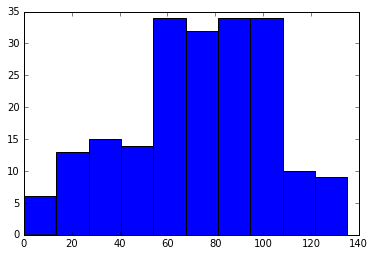

In [29]:
plt.hist(first_hist_data)

(array([ 10.,  36.,  59.,  56.,  19.,   6.,   4.,   4.,   3.,   4.]),
 array([  42.03307866,   48.83953685,   55.64599505,   62.45245324,
          69.25891144,   76.06536963,   82.87182783,   89.67828602,
          96.48474422,  103.29120241,  110.09766061]),
 <a list of 10 Patch objects>)

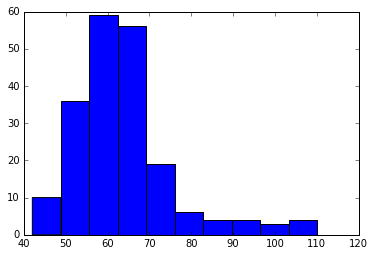

In [33]:
plt.hist(last_hist_data)


![](anim.gif)